In [31]:
# Importamos los módulos necesarios
import torch
import numpy as np
import matplotlib.pyplot as plt
import  os, sys
# necesitamos setear el path como variable de entorno para importar modulos
sys.path.append(os.path.join('..','..','libs'))
from read_smn import read_smn

# Incluyendo otras variables ambientales en la prediccion de la temperatura

Para una estación dada, se pueden pensar varios tipos de problemas: 

1. Conociendo los valores de temperatura (T), humedad (H), presión (P) y magnitud de la velocidad del viento (V) hasta la hora previa, predecir los valores de la siguiente hora.
2. Suponiendo que se rompe el sensor de temperatura, conociendo los valores históricos del conjunto (T, H, P, V) y además los valores actuales de (H,P,V) predecir la temperatura actual.
3. Ejercicio: Conociendo las variables de diferentes estaciones, predecir T, H, P y V para la hora siguiente (sugerencia: predecir para SALTA, utilizando TUCUMAN, JUJUY AERO)

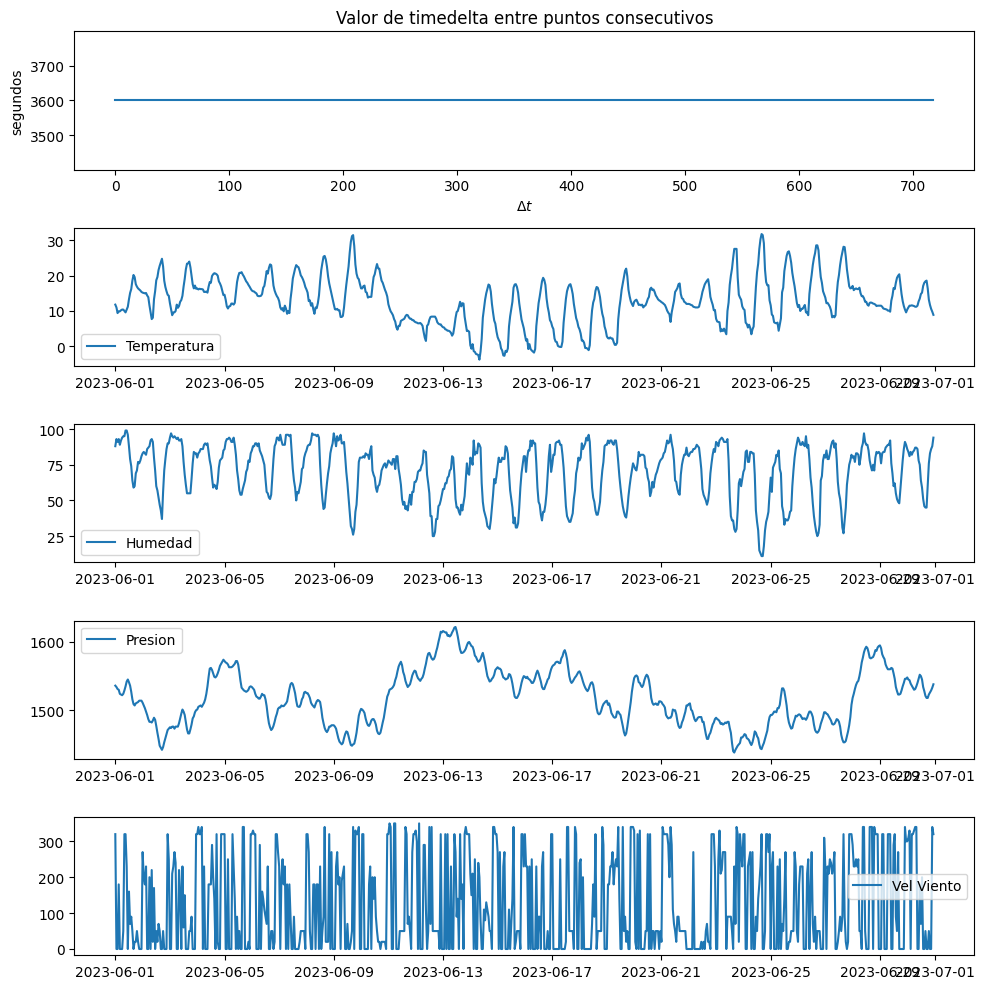

In [32]:
lector = read_smn(os.path.join('..','..','Data','junio-SMN','horario'))
tstamps, data = lector.filter_by_station('SALTA')

# verificamos que los datos estén completos
dt = tstamps[1:]-tstamps[:-1]
labels = ['Temperatura', 'Humedad', 'Presion', 'Vel Viento']
fig, axs = plt.subplots(5,1, figsize = (10,10))
axs[0].set_title('Valor de timedelta entre puntos consecutivos')
axs[0].set_xlabel('$\Delta t$')
axs[0].set_ylabel('segundos')
axs[0].plot([d.total_seconds() for d in dt])
for i in range(1,5):
    axs[i].plot(tstamps, data[:,i-1], label = labels[i-1])
    axs[i].legend()
fig.tight_layout()

## Acondicionando los datos

Como las diferentes series no tienen valores similares, es preciso normalizarlas de alguna manera para que la red neuronal las pese por igual a todas. Para ello vamos a utilizar las herramientas que proporciona Sci-Kit Learn.

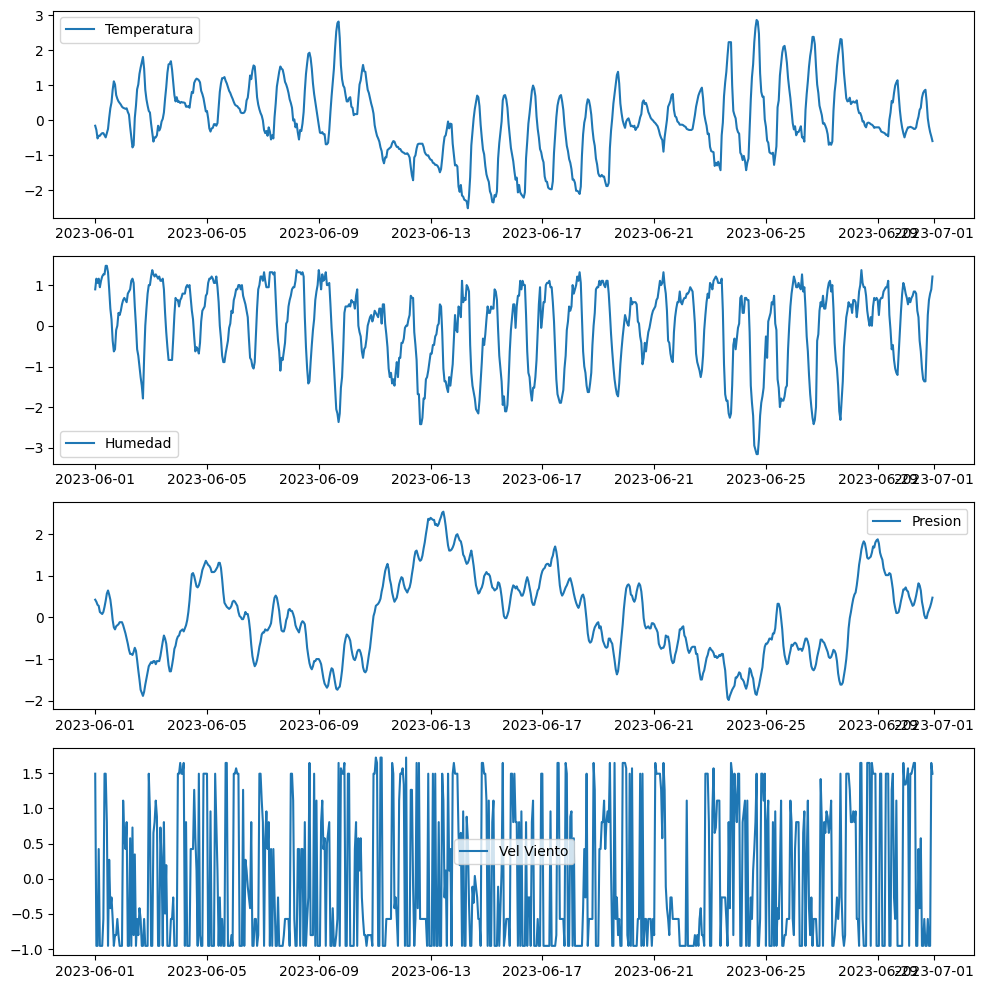

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data[:,:-1])
fig, axs = plt.subplots(4,1, figsize = (10,10))
for i in range(0,4):
    axs[i].plot(tstamps, data[:,i], label = labels[i])
    axs[i].legend()
fig.tight_layout()

In [37]:
# Vamos a separar todo el dataset en una parte de entrenamiento y otra de validacion
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data,test_size=0.2)
print(train.shape, test.shape)

(576, 4) (144, 4)


## Dataset y Dataloader

Vamos a crear un dataset para el ejercicio 1. Tomaremos una serie de datos previos (lookback), para predecir los datos futuros

In [62]:
class Dataset_delayed(torch.utils.data.Dataset):
    # constructor
    def __init__(self, data, lookback = 1):
        self.data = data
        self.lookback = lookback
        # partimos los datos en series con lookback
        self._split_X_Y()
        # convertimos los vectores de NumPy en tensores de PyTorch
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def _split_X_Y(self):
        self.X = []
        self.Y = []
        for i in range(self.data.shape[0]-self.lookback):
            self.X.append(self.data[i:i+self.lookback, :].flatten()) # Flatten reduce todo el vector a 1D
            self.Y.append(self.data[i+self.lookback,:])
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

In [64]:
# creamos los datasets y dataloaders en un diccionario para manejar mas simple
dataset = {'train': Dataset_delayed(train, lookback= 12),
           'valid' : Dataset_delayed(valid, lookback= 12)}

dataloader = {'train' : torch.utils.data.DataLoader(dataset['train'], batch_size = 32, shuffle= True),
            'valid' : torch.utils.data.DataLoader(dataset['valid'], batch_size = 32, shuffle= True)}

In [57]:
x,y

([array([  1,   2,   3,   4,  10,  20,  30,  40, 100, 200, 300, 400])],
 [array([1000, 2000, 3000, 4000])])